
时间步 1:
--------------------------------------------------
节点 1: 类型 = 真实系统, 信号 = s2, 攻击者信念 = 0.500, 攻击者行为 = attack, 攻击者效用 = 3.510, 防御者效用 = -9.483
节点 2: 类型 = 蜜罐, 信号 = s1, 攻击者信念 = 0.500, 攻击者行为 = attack, 攻击者效用 = -7.494, 防御者效用 = 0.003
节点 3: 类型 = 真实系统, 信号 = s1, 攻击者信念 = 0.500, 攻击者行为 = attack, 攻击者效用 = 4.506, 防御者效用 = -8.007
节点 4: 类型 = 蜜罐, 信号 = s2, 攻击者信念 = 0.500, 攻击者行为 = attack, 攻击者效用 = -4.504, 防御者效用 = -1.508
节点 5: 类型 = 真实系统, 信号 = s1, 攻击者信念 = 0.500, 攻击者行为 = attack, 攻击者效用 = 4.503, 防御者效用 = -8.016
节点 6: 类型 = 真实系统, 信号 = s1, 攻击者信念 = 0.500, 攻击者行为 = attack, 攻击者效用 = 4.490, 防御者效用 = -8.002
节点 7: 类型 = 真实系统, 信号 = s1, 攻击者信念 = 0.500, 攻击者行为 = attack, 攻击者效用 = 4.489, 防御者效用 = -8.017
节点 8: 类型 = 真实系统, 信号 = s1, 攻击者信念 = 0.500, 攻击者行为 = attack, 攻击者效用 = 4.498, 防御者效用 = -7.993
节点 9: 类型 = 真实系统, 信号 = s1, 攻击者信念 = 0.500, 攻击者行为 = attack, 攻击者效用 = 4.516, 防御者效用 = -7.993
节点 10: 类型 = 蜜罐, 信号 = s1, 攻击者信念 = 0.500, 攻击者行为 = attack, 攻击者效用 = -7.498, 防御者效用 = 0.005
节点 11: 类型 = 蜜罐, 信号 = s2, 攻击者信念 = 0.500, 攻击者行为 = attack, 攻击者效用 = -4.484, 防御者

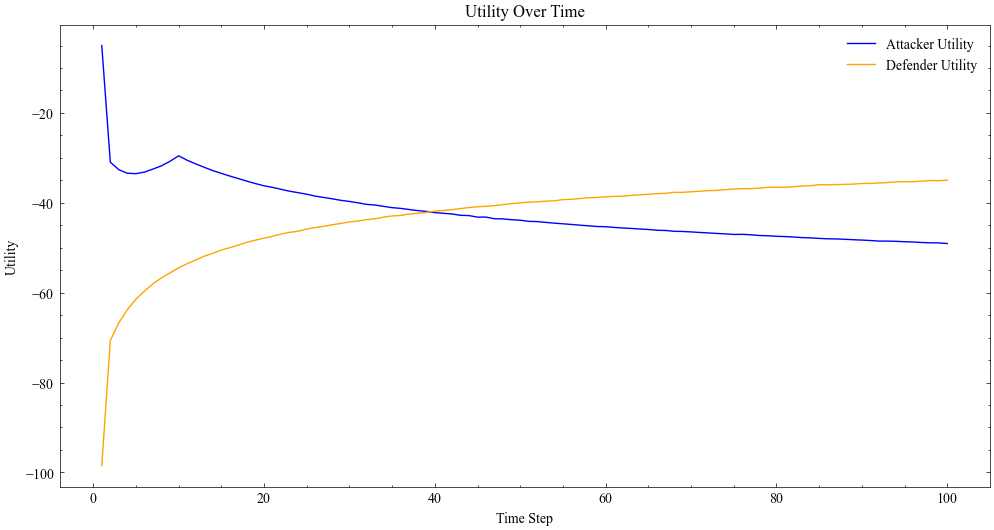

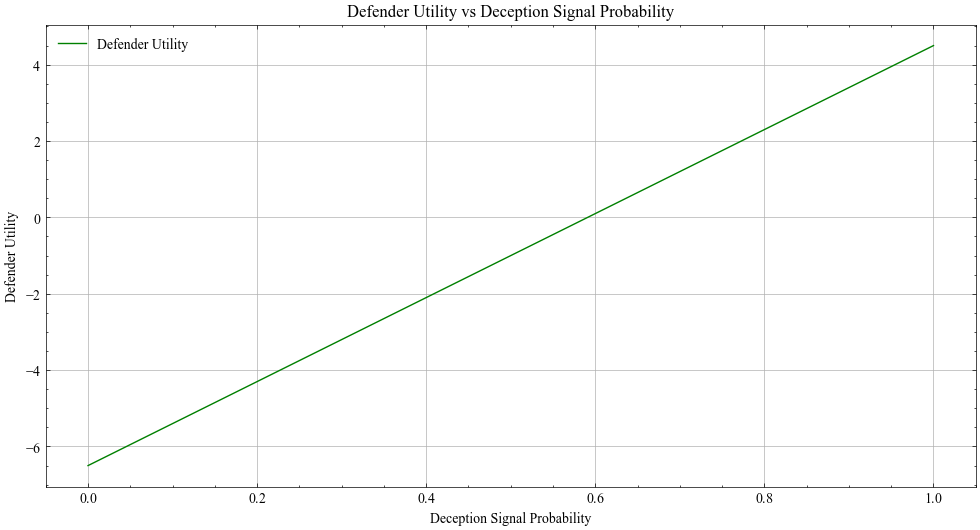

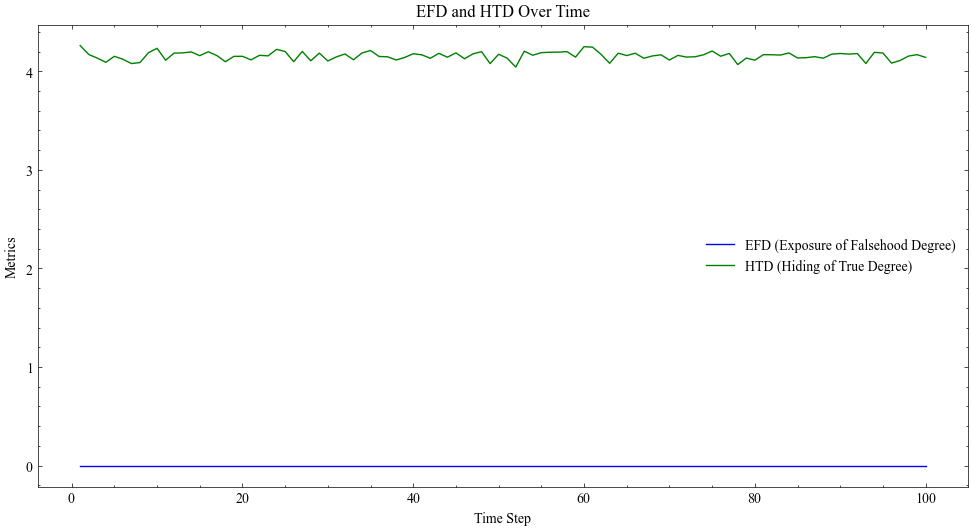

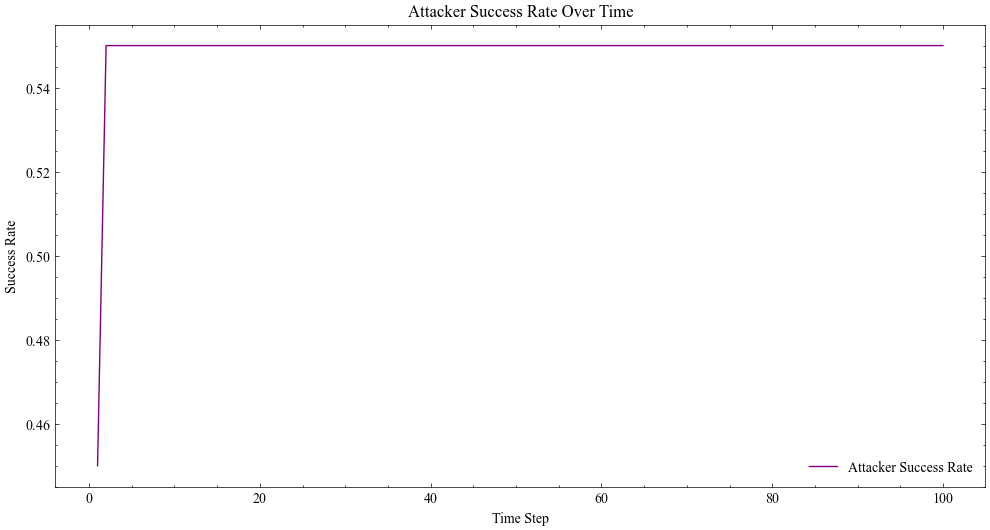

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager
from scipy.spatial.distance import euclidean
from scipy.stats import entropy
import seaborn as sns
import scienceplots
# # 设置Seaborn的主题为IEEE风格
# sns.set_theme(style="whitegrid", palette="muted", font="Times New Roman")

# 科学风格 + 明亮主题 + 中文支持
plt.style.use(['science', 'bright', 'no-latex', 'cjk-sc-font'])
# 设置字体为 Times New Roman
font_path = './front_path/Times_New_Roman.ttf'
font_manager.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.sans-serif'] = 'Times New Roman'

# 初始化参数
Ra_initial = 8  # 攻击者初始奖励
Ca1_initial, Ca2_initial, Ca3 = 2, 3, 6  # 攻击者的初始成本(攻击合法系统,攻击伪蜜罐,攻击高交互蜜罐)
Co = 1.5  # 攻击者探测的成本
Rds = 6  # 防御者伪装信号的奖励
CH = 5  # 防御者布置高交互蜜罐的成本
Rinf = 5  # 防御者通过影响攻击者信念获得的奖励
Rp = 5  # 攻击者避免被蜜罐捕获的奖励
CDs = 1.5  # 防御者部署伪装的成本
lambda_a = 0.2 # 攻击者奖励衰减因子
lambda_2 = 0.2  # 攻击者成本衰减因子
Rdec_initial = 8  # 防御者初始欺骗奖励
lambda_d = 0.2  # 防御者奖励衰减因子

# 时间步设置
T = 100  # 总时间步数
N = 20   # 节点数量（攻击目标或防御节点）

# 初始信念值
initial_belief = 0.5  # 攻击者对每个节点的初始信念
beliefs = np.full((N,), initial_belief)  # 初始化所有节点的信念

# 信念更新权重参数
δ = 0.3
T_half = T / 2  # 用于动态调整权重的中点

# 初始化效用和结果
attacker_utilities_t = []  # 每个时间步攻击者的总效用
defender_utilities_t = []  # 每个时间步防御者的总效用
belief_history = []        # 保存信念(综合信念)的历史记录
EFD_t = []                 # 曝露虚假程度的历史记录
HTD_t = []                 # 隐藏真实程度的历史记录

# 初始化攻击者成功率
success_rates = []  # 每个时间步攻击者成功率

noise_scale_attacker = 0.01  # 攻击者效用噪声标准差
noise_scale_defender = 0.01  # 防御者效用噪声标准差

# 定义邻居关系（用于信念更新）
def generate_neighbors(N):
    neighbors = {i: [i - 1, i + 1] for i in range(N)}  # 每个节点的邻居（前后相邻节点）
    for i in neighbors:
        neighbors[i] = [n for n in neighbors[i] if 0 <= n < N]  # 排除越界的邻居
    return neighbors
neighbors = generate_neighbors(N)


#攻击者行为与信号事件计数
#attack:0,retreat:1
#s1:0,s2:1
action_signal_matrix = [[0,0],[0,0]]

# 初始化防御节点类型（真实系统 θ1 或蜜罐 θ2）
defense_types = np.random.choice([0, 1], size=N, p=[0.5, 0.5])  # 随机初始化节点类型
num_detected = 0  # 被蜜罐捕获的攻击次数
num_probes = 0    # 攻击者探测次数


def generate_X(signal):
    """
        生成所有节点的信号特征向量
        signal: 信号类型(s1:正常,s2:蜜罐)
        internal:
             - X_N:信号向量维度(属性的个数)
             - X_M:信号取值范围标签(0~9)
             - 标签单数为正常属性,双数为蜜罐属性
    """
    X_N = 10
    X_M = 10
    X = np.zeros(X_N)
    selected_indices = np.random.choice(X_N, 6, replace=False)
    if signal == "s1":
        for i in range(X_N):
            if i in selected_indices:
                X[i] = np.random.choice(range(1, X_M, 2))
            else:
                X[i] = np.random.randint(0,X_M)
    else:
        for i in range(X_N):
            if i in selected_indices:
                X[i] = np.random.choice(range(0,X_M,2))
            else:
                X[i] = np.random.randint(0,X_M)
    return X



def caculate_attacker_observation(action_signal_matrix,theta,signal):
    """
        计算攻击者观测概率(条件概率)
        action_signal_matrix: 事件观察矩阵2*2
        theta: 攻击者行为(0:攻击,1:不攻击)
        signal: 防御者信号(0:正常,1:蜜罐)
        internal:
            - [0,0]:攻击者攻击,正常信号
            - [0,1]:攻击者攻击,蜜罐信号
            - [1,0]:攻击者撤退,正常信号
            - [1,1]:攻击者撤退,蜜罐信号
    """
    observation_theta = 0
    if theta == 0:
        if signal == 0:
            if sum(action_signal_matrix[0]) != 0:
                observation_theta = action_signal_matrix[0][0] / sum(action_signal_matrix[0])
            print(f"攻击者攻击,正常信号的概率: {observation_theta}")
        else:
            if sum(action_signal_matrix[0]) != 0:
                observation_theta = action_signal_matrix[0][1] / sum(action_signal_matrix[0])
            print(f"攻击者攻击,蜜罐信号的概率: {observation_theta}")
    else:
        if signal == 0:
            if sum(action_signal_matrix[1]) != 0:
                observation_theta = action_signal_matrix[1][0] / sum(action_signal_matrix[1])
            print(f"攻击者撤退,正常信号的概率: {observation_theta}")
        else:
            if sum(action_signal_matrix[1]) != 0:
                observation_theta = action_signal_matrix[1][1] / sum(action_signal_matrix[1])
            print(f"攻击者撤退,蜜罐信号的概率: {observation_theta}")
    return observation_theta


def calculate_EFD(X_list,normal_signal_nodes):
    """
        计算曝露虚假程度(EFD)
        X_list: 所有节点的信号特征向量列表
        normal_signal_nodes: 发送正常信号节点的索引列表
    """
    if len(X_list) == 0:
        return 0
    n = len(X_list)
    efd = 0
    #计算所有蜜罐节点与正常节点的属性向量距离
    honeypot_X_list = [X_list[i] for i in range(n) if i not in normal_signal_nodes]
    normal_X_list = [X_list[i] for i in range(n) if i in normal_signal_nodes]
    for honeypot_X in honeypot_X_list:
        for normal_X in normal_X_list:
            dist = np.linalg.norm(np.array(honeypot_X) - np.array(normal_X))
            efd += dist
    efd /= max(1,len(honeypot_X_list) * len(normal_X_list))
    print(f"new EFD: {efd}")
    return efd

def calculate_HTD(X_list):
    """
        计算隐藏真实程度(HTD)
        X_list: 所有节点的信号特征向量列表
        internal:
            - X_count_matrix: 属性向量计数矩阵
            - X_count_matrix[i][j]: 属性i的j类型出现的次数
    """
    if len(X_list) == 0:
        return 0
    htd = 0
    X_count_matrix = np.zeros((10, 10))
    for X in X_list:
        for i in range(len(X)):
            if 0 <= X[i] < 10:  # 确保 X[i] 在有效范围内
                X_count_matrix[i][int(X[i])] += 1  # 确保 X[i] 是整数
    X_count_matrix = X_count_matrix / max(1, np.sum(X_count_matrix))
    for i in range(10):
        for j in range(10):
            if X_count_matrix[i][j] > 0:  # 避免 log(0)
                htd += X_count_matrix[i][j] * np.log(X_count_matrix[i][j])
    htd = -htd

    print(f"new HTD: {htd}")
    return htd


# 主循环：逐时间步模拟交互
for t in range(1, T + 1):
    # 动态调整信念更新权重
    alpha = 1 / (1 + np.exp(-(t - T_half) / (T / 10)))  # 自身信念的权重(时间步越大,权重越小)
    beta = 1 - alpha  # 来自伪装信号的权重
    gamma = δ * alpha * (1 - t / T)  # 邻居信念的权重

    # 初始化时间步的总效用
    attacker_utility_t = 0  # 当前时间步攻击者的总效用
    defender_utility_t = 0  # 当前时间步防御者的总效用
    new_beliefs = np.zeros_like(beliefs)  # 用于存储更新后的信念
    efd = 0  # 曝露虚假程度累加器
    htd = 0  # 隐藏真实程度累加器
    real_count = 0  # 真实系统节点的数量
    success_count = 0  # 攻击者成功攻击的次数
    # 节点属性向量集
    X_list = []
    normal_signal_nodes = []
    print(f"\n时间步 {t}:")
    print("--------------------------------------------------")

    # 遍历所有节点
    for i in range(N):
        if t == 1:
            # 时间步 1，防御者随机选择信号（无攻击者的行动历史）
            signal = "s1" if np.random.rand() < 0.5 else "s2"
            psi_t_s1 = initial_belief  # 信念未更新，使用初始值
            psi_t_s2 = initial_belief
            # 初始化攻击者参数
            Ra_t = Ra_initial
            Ca1_t = Ca1_initial
            Ca2_t = Ca2_initial #攻击高交互蜜罐成本
        else:
            # 计算攻击者观测概率(根据攻击者历史行为计算)
            observation_theta1_s1 = caculate_attacker_observation(action_signal_matrix,0,0) #攻击,正常
            observation_theta1_s2 = caculate_attacker_observation(action_signal_matrix,0,1) #攻击,蜜罐
            observation_theta2_s1 = caculate_attacker_observation(action_signal_matrix,1,0) #不攻击,正常
            observation_theta2_s2 = caculate_attacker_observation(action_signal_matrix,1,1) #不攻击,蜜罐

            # 信念更新（原始信念）
            # 后验信念1-发出s1,攻击者攻击信念
            phi_theta1_s1 = beliefs[i] * observation_theta1_s1 / (beliefs[i] * observation_theta1_s1 + 
                                                               (1 - beliefs[i]) * observation_theta2_s1)
            phi_theta2_s1 = 1 - phi_theta1_s1
            # 后验信念2-发出s2,攻击者攻击信念
            phi_theta1_s2 = beliefs[i] * observation_theta1_s2 / (beliefs[i] * observation_theta1_s2 + 
                                                               (1 - beliefs[i]) * observation_theta2_s2)
            phi_theta2_s2 = 1 - phi_theta1_s2

            z_actual_s1 = phi_theta1_s1+np.random.rand()*0.1 #增加随机噪声(模拟观测值)
            z_actual_s2 = phi_theta1_s2+np.random.rand()*0.1 #增加随机噪声(模拟观测值)
            K_t = 0.8 / t  # 卡尔曼增益随时间增加而减少
            phi_prime_theta1_s1 = phi_theta1_s1 + K_t * (z_actual_s1 - phi_theta1_s1)  # 使用卡尔曼滤波更新
            phi_prime_theta1_s2 = phi_theta1_s2 + K_t * (z_actual_s2 - phi_theta1_s2)

            # 邻居综合信念的加权平均
            neighbor_beliefs = [beliefs[n] for n in neighbors[i]]
            neighbor_weights = np.array([1 / (abs(i - n) + 1) for n in neighbors[i]])
            neighbor_weights /= neighbor_weights.sum()
            psi_neighbor = np.dot(neighbor_weights, neighbor_beliefs)

            # 计算综合信念(历史综合信念+滤波信念+邻居信念)
            psi_t_s1 = alpha *beliefs[i] + beta * phi_prime_theta1_s1   + gamma * psi_neighbor
            psi_t_s2 = alpha *beliefs[i] + beta * phi_prime_theta1_s2   + gamma * psi_neighbor
            # 信念越大攻击者攻击的概率就越大(这个是攻击者历史信念，根据之前的信息更新)
            psi_t_s1 = max(0, min(1, psi_t_s1))  # 在发出s1信号(正常)时，攻击者攻击的概率
            psi_t_s2 = max(0, min(1, psi_t_s2))  # 在发出s2信号(蜜罐)时，攻击者攻击的概率

            # 计算防御者的期望效用(攻击者根据历史产生了信念，这种条件下防御者不同信号下的效用)
            if defense_types[i] == 0:  # 防御者类型 θ1
                Ra_t = max(Ra_initial * np.exp(-lambda_a * np.log(t + 1)), 0)
                Ca1_t = max(Ca1_initial * (1 - lambda_2 * min(num_probes, t / 2)), 0) #攻击合法系统成本随攻击者探测次数和时间步增加而增加
                Ca2_t = max(Ca2_initial / (1 + lambda_2 * min(num_probes, t / 2)), 0.1) #攻击伪蜜罐成本随攻击者探测次数和时间步增加而减少
                EU_D_s1 = psi_t_s1 * (-Ra_t) + psi_t_s2 * Rds - CDs
                EU_D_s2 = psi_t_s2 * (-Ra_t - Rds) + psi_t_s1 * (-CH + Rinf) - CDs
            else:  # 防御者类型 θ2
                Rdec_t = max(Rdec_initial * np.exp(-lambda_d * num_detected), 0)
                EU_D_s1 = psi_t_s1 * (-CH) + psi_t_s2 * (Rp) - CDs
                EU_D_s2 = psi_t_s2 * (-CH - Rds) + psi_t_s1 * (-CH + Rdec_t) - CDs

            
            # 防御者根据效用选择信号
            if EU_D_s1 > EU_D_s2:
                signal = "s1"
                belief_update = psi_t_s1
                normal_signal_nodes.append(i)
            else:
                signal = "s2"
                belief_update = psi_t_s2
                
        # 生成节点属性向量
        X = generate_X(signal)
        X_list.append(X)

        

        # 攻击者的行为选择(根据预期效用)
        if signal == "s1":
            EU_A_attack = psi_t_s1 * (Ra_t - Ca1_t - Co) + psi_t_s2 * (-CH + Rinf)
            EU_A_retreat = -Co
        else:
            EU_A_attack = psi_t_s2 * (Ra_t - Ca2_t - Co) + psi_t_s1 * (-CH - Rds + Rinf)
            EU_A_retreat = -Co

        if EU_A_attack > EU_A_retreat:  # 攻击者选择攻击
            attacker_action = "attack"
            num_probes += 1
            if signal == "s1":
                #更新攻击者观测事件矩阵
                action_signal_matrix[0][0] += 1
                if defense_types[i] == 0:
                    attacker_utility = Ra_t - Ca1_t - Co
                    defender_utility = -Ra_t
                    success_count += 1
                else:
                    attacker_utility = -Ca3 - Co
                    defender_utility = -CH + Rinf
            else:
                #更新攻击者观测事件矩阵
                action_signal_matrix[0][1] += 1
                if defense_types[i] == 0:
                    attacker_utility = Ra_t - Ca2_t - Co
                    defender_utility = -Ra_t - CDs
                else:
                    attacker_utility = -Ca2_t - Co
                    defender_utility = -CH - CDs + Rinf
        else:  # 攻击者选择撤退
            attacker_action = "retreat"
            if signal == "s1":
                #更新攻击者观测事件矩阵
                action_signal_matrix[1][0] += 1
                if defense_types[i] == 0:
                    attacker_utility = -Co
                    defender_utility = 0
                else:
                    attacker_utility = -Co + Rp
                    defender_utility = -CH
            else:
                #更新攻击者观测事件矩阵
                action_signal_matrix[1][1] += 1
                if defense_types[i] == 0:
                    attacker_utility = -Co
                    defender_utility = Rds - CDs
                else:
                    attacker_utility = -Co + Rp
                    defender_utility = -CH - CDs

        # 添加随机噪声
        attacker_utility += np.random.normal(0, noise_scale_attacker)
        defender_utility += np.random.normal(0, noise_scale_defender)

      

        # 更新信念
        if t > 1:
            new_beliefs[i] = belief_update

        # 累加效用
        attacker_utility_t += attacker_utility
        defender_utility_t += defender_utility
    # 打印当前时间步信息
    print(f"时间步 {t}: 攻击者成功率 = {success_count / N:.3f}, EFD = {efd:.3f}, HTD = {htd:.3f}")
    # 计算 EFD 和 HTD
    # 计算EFD和HTD
    efd = calculate_EFD(X_list,normal_signal_nodes)
    htd = calculate_HTD(X_list)
    # 保存时间步的统计数据
    success_rates.append(success_count / N)
    EFD_t.append(efd)
    HTD_t.append(htd)

    # 更新信念
    if t > 1:
        beliefs = new_beliefs

    # 保存时间步效用
    attacker_utilities_t.append(attacker_utility_t)
    defender_utilities_t.append(defender_utility_t)




# 绘制攻击者和防御者效用随时间变化的曲线
plt.figure(figsize=(12, 6))
plt.plot(range(1, T + 1), attacker_utilities_t, label="Attacker Utility", color="blue")
plt.plot(range(1, T + 1), defender_utilities_t, label="Defender Utility", color="orange")
plt.legend()
plt.xlabel("Time Step")
plt.ylabel("Utility")
plt.title("Utility Over Time")
plt.savefig("utility_over_time_high_dpi.png", dpi=400)
plt.show()

# 绘制防御者收益随伪装信号概率变化的曲线
defender_utilities = []
deception_probs = np.linspace(0, 1, 50)
for p in deception_probs:
    utility = p * Rds - CDs - (1 - p) * CH
    defender_utilities.append(utility)

plt.figure(figsize=(12, 6))
plt.plot(deception_probs, defender_utilities, label="Defender Utility", color="green")
plt.xlabel("Deception Signal Probability")
plt.ylabel("Defender Utility")
plt.title("Defender Utility vs Deception Signal Probability")
plt.legend()
plt.grid()
plt.savefig("defender_utility_vs_deception_probability.png", dpi=400)
plt.show()

# 绘制 EFD 和 HTD 随时间变化的曲线
plt.figure(figsize=(12, 6))
plt.plot(range(1, T + 1), EFD_t, label="EFD (Exposure of Falsehood Degree)", color="blue")
plt.plot(range(1, T + 1), HTD_t, label="HTD (Hiding of True Degree)", color="green")
plt.legend()
plt.xlabel("Time Step")
plt.ylabel("Metrics")
plt.title("EFD and HTD Over Time")
plt.savefig("efd_htd_over_time_high_dpi.png", dpi=400)
plt.show()

# 绘制攻击者成功率随时间变化的曲线
plt.figure(figsize=(12, 6))
plt.plot(range(1, T + 1), success_rates, label="Attacker Success Rate", color="purple")
plt.legend()
plt.xlabel("Time Step")
plt.ylabel("Success Rate")
plt.title("Attacker Success Rate Over Time")
plt.savefig("attacker_success_rate_high_dpi.png", dpi=400)
plt.show()
